# Create DynamoDB table, IAM, and API Gateway

Credits Educative.io

### Create DynamoDB

Creating DynamoDB table (we'll call it `Fruit`) is straightforward in the AWS console.

To put some items into it we can directly call database:
```python

import boto3

# Initializing the DynamoDB client
dynamodb = boto3.client(
  'dynamodb',
  aws_access_key_id='XYZ',
  aws_secret_access_key='XYZ',
  region_name='us-east-1'
)

# Defining a function to insert items into the table using the put_item method
def insert_fruit(name, color, flavor):
  response = dynamodb.put_item(
    TableName='Fruits',
    Item={
      'Name': { 'S': name },
      'Color': { 'S': color },
      'Flavor': { 'S': flavor }
    }
  )

# Inserting four items into the table
insert_fruit('Apple', 'Red', 'Sweet')
insert_fruit('Apple', 'Green', 'Sour')
insert_fruit('Lemon', 'Yellow', 'Sour')
print('Table populated successfully.')
```

However, we want to interact with database via REST API as it is more optimal and versatile (like using it in a webpage) then calling `boto3.client`.

### Set IAM

Let's first create an IAM (Identity and Access Management) role, with custom trust policy:
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "apigateway.amazonaws.com"
            },
            "Action": "sts:AssumeRole"
        }
    ]
}
```

this role get ARN (Amazon Resource Number):

`arn:aws:iam::XXXXXXXXX:role/APIGatewayExecutionRole`
`arn:aws:iam::493296643293:role/APIGatewayExecutionRole`

### Set API Gateway

API Gateway "act as the "front door" for applications to access data, business logic, or functionality from your backend services".

### Set up GET method

Although we’re setting up a GET method, the GET request on the /fruit/{name} resource will map to a POST request to the GetItem endpoint of the DynamoDB API:

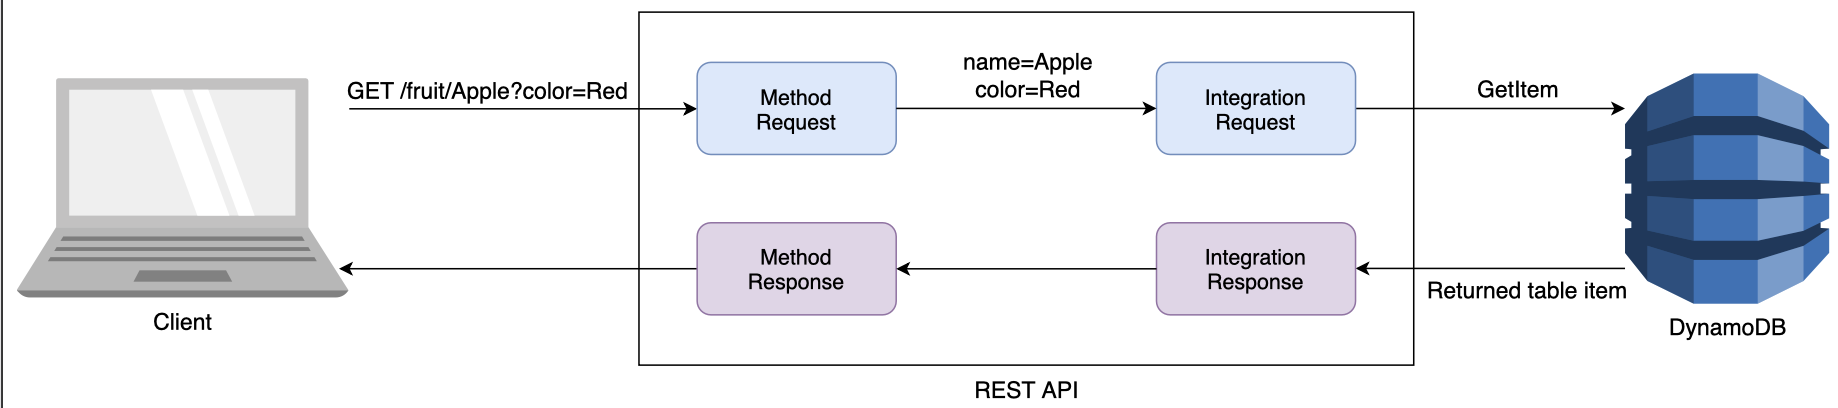

Under "Method Request" we can define `color` as required for “URL Query String Parameters”.

Under "Integration Request" we define:
1) "URL Path Parameters", we use `method.request.path.name`. This configuration enables API Gateway to map the {name} path parameter from incoming requests to the name parameter.

2) URL query string parameters: we use `method.request.querystring.color`. This maps the color query parameter to the color parameter that will be used in the mapping template.

3) Finally we define a mapping model:
```
{
    "TableName": "Fruits",
    "Key": {
        "Name": {
            "S": "$input.params("name")"
        },
        "Color": {
            "S": "$input.params("color")"
        }
    }
}
```


### Set up POST method

For POST, we first need to create model:

```
{
  "$schema": "http://json-schema.org/draft-04/schema#",
  "title": "AddFruitModel",
  "type": "object",
  "properties": {
    "name": {
      "type": "string"
    },
    "color": {
      "type": "string"
    },
    "flavor": {
      "type": "string"
    }
  }
}
```

We then add this model to "Method Request" under "Request Body".

For "Integration Request" we define a "Mapping template":


```
#set($inputRoot = $input.path('$'))
{
    "TableName": "Fruits",
    "Item": {
        "Name": {"S": "$inputRoot.name"},
        "Color": {"S": "$inputRoot.color"},
        "Flavor": {"S": "$inputRoot.flavor"}
    }
}
```

## Deploy

We now deploy API, this creates a stage (name it as "v1" for example).

To test GET:
```
import json
import requests

url = 'https://XXXXXXX.execute-api.us-east-1.amazonaws.com/v1'
fruit = 'Lemon'
color = 'Yellow'
final_url = f'{url}/fruit/{fruit}'

response = requests.get(final_url, params = { 'color' : color }).json()

print(json.dumps(response, indent=4))
```

To test POST:
```
import json
import requests

url = 'https://XXXXXX.execute-api.us-east-1.amazonaws.com/v1'
new_fruit = {
    'name': 'Grapes',
    'color': 'Green',
    'flavor': 'Sour'
}
final_url = f'{url}/fruit'

response = requests.post(final_url, json=new_fruit).json()
print(json.dumps(response, indent=4))

final_url = f'{url}/fruit/Grapes'
response = requests.get(final_url, params = { 'color' : 'Green' }).json()
print(json.dumps(response, indent=4))
```

Both give response indicating everything is ok.

The part of the setup looks like this where we had to create GET and POST methods, set up model, method Request, integration request, and  deploy API:

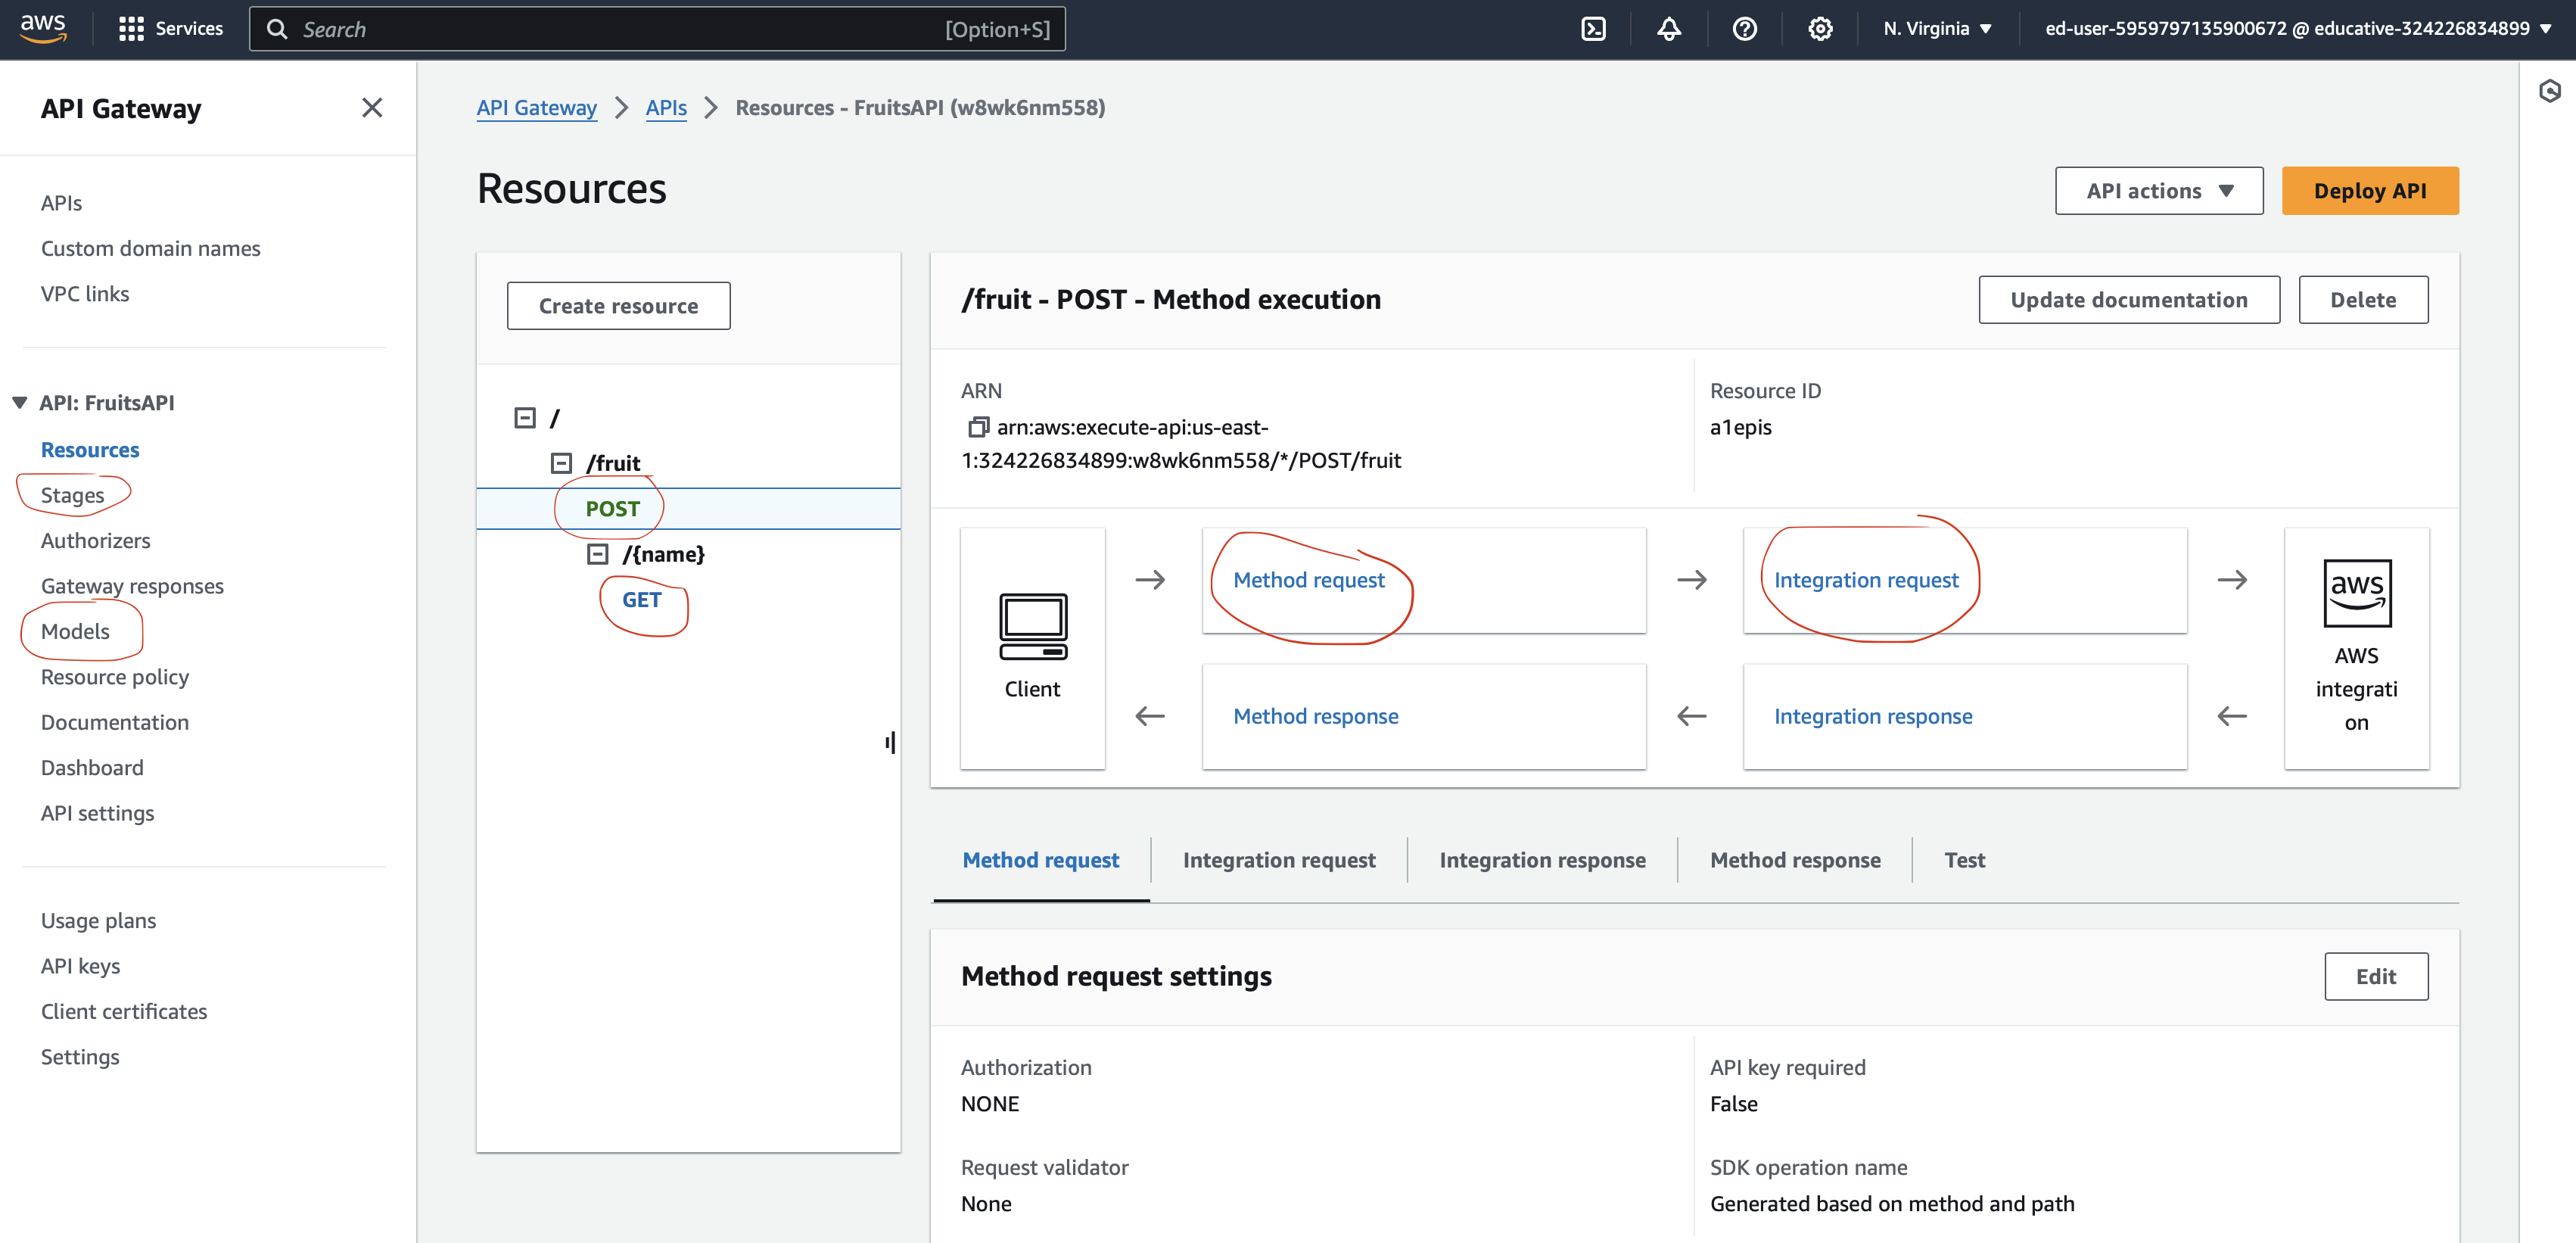